# Getting started with Poincare
Poincare is a python library for declaring and simulating dynamical systems. Designed around the principle of modularity, composability and reproducibility, it's intended to create a layer to separate the actual declaration of models from their simulation, allowing to easily switch methods and backends. It also makes models composable, allowing the combination of smaller systems to create larger ones, and makes it easy to extract information (parameters, equations, etc...) from models, encouraging consistency between analytical formulations and numerical implementations.


### Installation 

It can be installed from PyPI:


```
pip install -U poincare
```

or conda-forge:

```
conda install -c conda-forge poincare
```

In [ ]:
# Actually install poincare in environment
! pip install poincare

### Creating and symultaing a system
Systems are represented as a subclass of the `System` Class. To create one with equations: 
$$ \frac{dx}{dt} = -x \quad \text{with} \quad x(0) = 1 $$
we can write:

In [1]:
from poincare import Variable, System, initial


class Model(System):
    # Define a variable with name `x` with an initial value (t=0) of `1``.
    x: Variable = initial(default=1)
    # The rate of change of `x` (i.e. velocity) is assigned (<<) to `-x`.
    # This relation is assigned to a Python variable (`eq`)
    eq = x.derive() << -x

To simulate that system we must create a `Simulator` for it: 

<Axes: xlabel='time'>

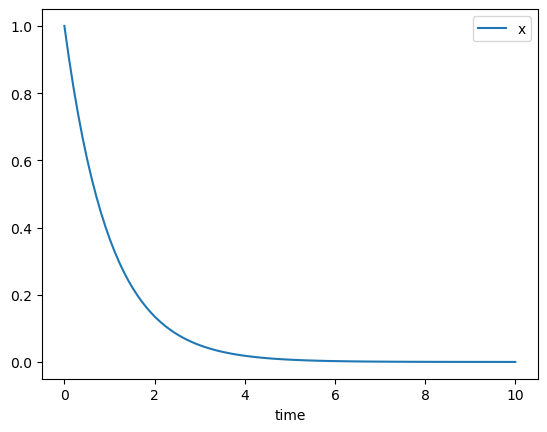

In [2]:
from poincare import Simulator
import numpy as np

# Create a simulator for Model
sim = Simulator(Model)

# Solve the model and save the resulting pandas dataframe to "result"
result = sim.solve(save_at=np.linspace(0, 10, 100))
result.plot()


The output is a `pandas.DataFrame`,
which can be plotted with `.plot()`. 

We can change the initial conditions by passing a `values` dictionary to `solve`; it is possible to create more than one solution with different initial conditions from the same `Simulator`, avoiding model recompilation.


In [3]:
sim = Simulator(Model)
result1 = sim.solve(values={Model.x: 2}, save_at=range(3))
print("Result 1  \n", result1)

result2 = sim.solve(values={Model.x: 3}, save_at=range(3))
print("Result 2 \n", result2)

Result 1  
              x
time          
0     2.000000
1     0.736278
2     0.271002
Result 2 
              x
time          
0     3.000000
1     1.104417
2     0.406502


### Higher order systems
To define a higher-order system, we have to explicitly define and assign an initial condition to the derivative of a variable:

<Axes: xlabel='time'>

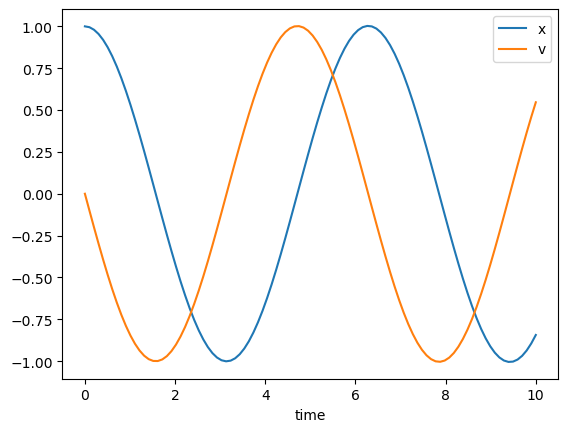

In [4]:
from poincare import Derivative


class Oscillator(System):
    # Define a variable with name `x` with an initial value (t=0) of `1``.
    x: Variable = initial(default=1)
    # Define `v` as the derivative of `x` with an intital value of `0`
    v: Derivative = x.derive(initial=0)

    eq = v.derive() << -x


result = Simulator(Oscillator).solve(save_at=np.linspace(0, 10, 100))
result.plot()

### Non-autonomous systems

To use the independent variable,
we create an instance of `Independent`:

In [5]:
from poincare import Independent


class NonAutonomous(System):
    time = Independent()
    x: Variable = initial(default=0)
    eq = x.derive() << 2 * time


Simulator(NonAutonomous).solve(save_at=range(3))

,x
time,
0,0.000000
1,1.000001
2,4.000001


### Transforming output
We can compute transformations of the output
by passing a dictionary `transform = {"name": expression}` of expressions to calculate:

<Axes: xlabel='time'>

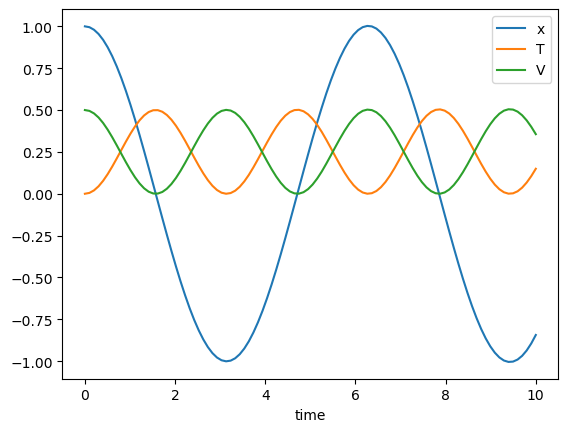

In [6]:
# Compute kinetic and potential energy
result = Simulator(
    Oscillator,
    transform={
        "x": Oscillator.x,
        "T": 1 / 2 * Oscillator.v**2,
        "V": 1 / 2 * Oscillator.x**2,
    },
).solve(
    save_at=np.linspace(0, 10, 100),
)
result.plot()

Note that the output will only save whatever is passed to transform, so the original variables must be explicitly passed in order to be included.

### Constants, Parameters, and functions

Besides variables,
we can define parameters and constants,
and use functions from [Symbolite](https://github.com/hgrecco/symbolite).

#### Constants

Constants allow to define common initial conditions for Variables and Derivatives:

In [7]:
from poincare import assign, Constant


class ModelXY(System):
    c: Constant = assign(default=1, constant=True)
    x: Variable = initial(default=c)
    y: Variable = initial(default=2 * c)
    eq_x = x.derive() << -x
    eq_y = y.derive() << -y


Simulator(ModelXY).solve(save_at=range(3))

,x,y
time,,
0,1.000000,2.000000
1,0.368139,0.736278
2,0.135501,0.271002


Now, we can vary their initial conditions jointly:


In [8]:
Simulator(ModelXY).solve(values={ModelXY.c: 2}, save_at=range(3))

,x,y
time,,
0,2.000000,4.000000
1,0.736278,1.472556
2,0.271001,0.542003


But we can break that connection by passing `y`'s initial value directly:


In [9]:
Simulator(ModelXY).solve(values={ModelXY.c: 2, ModelXY.y: 2}, save_at=range(3))

,x,y
time,,
0,2.000000,2.000000
1,0.736278,0.736278
2,0.271002,0.271002


#### Parameters

Parameters are like Variables,
but their time evolution is given directly as a function of time,
Variables, Constants and other Parameters:

In [10]:
from poincare import Parameter


class ParametrizedDecay(System):
    p: Parameter = assign(default=1)
    x: Variable = initial(default=1)
    eq = x.derive() << -p * x


# We can use a value other than the default for parameter `p` when solving the system
Simulator(ParametrizedDecay).solve(save_at=range(3), values={ParametrizedDecay.p: 0.5})
Simulator(ParametrizedDecay).solve(save_at=range(3), values={ParametrizedDecay.p: 2})

,x
time,
0,1.000000
1,0.135541
2,0.018356


### Functions
Symbolite functions are accessible from the `symbolite.scalar` module:

In [11]:
from symbolite import scalar


class ParametrizedForce(System):
    x: Variable = initial(default=1)
    F: Parameter = assign(default=scalar.sin(x))

    eq = x.derive() << F


Simulator(ParametrizedForce).solve(save_at=range(3))

,x
time,
0,1.000000
1,1.951464
2,2.654572


Note how `F` is a function of `x`. Parameters which depend on variables cannot be changed after model compilation:

In [12]:
try:
    Simulator(ParametrizedForce).solve(
        save_at=range(3),
        values={ParametrizedForce.F: scalar.cos(ParametrizedForce.x)},
    )
except ValueError as ve:
    # Poincare Raises a ValueError when the functional dependece of a parameter is changed
    print("ValueError:", ve)

ValueError: must recompile to change time-dependent assignments


Instead we must recompile the model with the new value:

In [13]:
# crate a new simulator with the new formula for `F`
new_sim = Simulator(ParametrizedForce(F=scalar.cos(ParametrizedForce.x)))
new_sim.solve(save_at=range(3))

,x
time,
0,1.000000
1,1.356033
2,1.490887


### Model reports

Aside for its use in simulation, Poincare is meant to be a centralized for source for all information concerning the system. To ensure consistency between analytical formulations and numerical implementations, we can use the `model_report()` function to generate LaTeX code for a report with all relevant model data (equations, variables and parameters):

In [14]:
from poincare import model_report

print(model_report(ParametrizedDecay))

\documentclass{article}

        \usepackage{amsmath}
        \usepackage{float}
        
        \setcounter{secnumdepth}{0}

        \begin{document}
        
    \subsection{Equations} 
    
    \[ \begin{aligned}
\frac{dx}{dt}&=- p x\\
\end{aligned} \]
    
    
    \subsection{Variables}

    \begin{table}[H]
    \begin{tabular}{|c|c|c|}
\hline
Variable & Default & Derivative \\ 
 \hline \hline 
$x$ & $1$ & $-$ \\ 
 \hline 
\end{tabular}
    \end{table}
    
    
    \subsection{Parameters}

    \begin{table}[H]
    \begin{tabular}{|c|c|}
\hline
Parameter & Default \\ 
 \hline \hline 
$\text{p}$ & $1$ \\ 
 \hline 
\end{tabular}
    \end{table}

    \end{document}


instead of printing the output a file path can be passed for `model_report()` to write on:

In [ ]:
model_report(ParametrizedDecay, path="Parametrized_Decay_report.tex")

The `standalone` argument decides wether it should compile as a standalone document (by including headers such as "\documentclass", "\begin{document}") or is meant to be added to a an existing document; when a path is passed it also controls if it overwrites existing contents (if `True`) or it appends (if `False`). It is true by default.

In [16]:
print(model_report(ParametrizedDecay, standalone=False))


    \subsection{Equations} 
    
    \[ \begin{aligned}
\frac{dx}{dt}&=- p x\\
\end{aligned} \]
    
    
    \subsection{Variables}

    \begin{table}[H]
    \begin{tabular}{|c|c|c|}
\hline
Variable & Default & Derivative \\ 
 \hline \hline 
$x$ & $1$ & $-$ \\ 
 \hline 
\end{tabular}
    \end{table}
    
    
    \subsection{Parameters}

    \begin{table}[H]
    \begin{tabular}{|c|c|}
\hline
Parameter & Default \\ 
 \hline \hline 
$\text{p}$ & $1$ \\ 
 \hline 
\end{tabular}
    \end{table}

    


### Units

poincaré also supports functions through
[`pint`](https://github.com/hgrecco/pint)
and [`pint-pandas`](https://github.com/hgrecco/pint-pandas).

In [17]:
import pint

unit = pint.get_application_registry()


class UnitModel(System):
    x: Variable = initial(default=1 * unit.m)
    v: Derivative = x.derive(initial=0 * unit.m / unit.s)
    w: Parameter = assign(default=1 * unit.Hz)
    eq = v.derive() << -(w**2) * x


result = Simulator(UnitModel).solve(save_at=range(3))
result


,x,v
time,,
0,1.0,0.0
1,0.5403662294551165,-0.841561161473883
2,-0.4163083386904191,-0.9097912919358292


The columns have units of `m` and `m/s`, respectively.
`pint` raises a `DimensionalityError` if we try to add them:

In [18]:
from pint import DimensionalityError

try:
    result["x"] + result["v"]
except DimensionalityError as de:
    print("DimensionalityError: ", de)

DimensionalityError:  Cannot convert from 'meter' ([length]) to 'meter / second' ([length] / [time])


We can remove the units and set them as string metadata with:


In [19]:
result.pint.dequantify()

,x,v
unit,meter,meter / second
time,,
0,1.0,0.0
1,0.540366,-0.841561
2,-0.416308,-0.909791


which allows to plot the DataFrame with `.plot()`.
